In [11]:
import numpy as np
import librosa
from scipy.signal import get_window
import matplotlib.pyplot as plt

# --- Helpers from Exercise 1 ---
def compute_acf_matrix(m_frames: np.ndarray) -> np.ndarray:
    """
    Compute autocorrelation (ACF) for each frame (non-negative lags only).
    """
    num_frames, L = m_frames.shape
    acf_matrix = np.zeros((num_frames, L))
    for i in range(num_frames):
        acf_full = np.convolve(m_frames[i], m_frames[i][::-1], mode='full')
        # keep lags >= 0 (center index L-1)
        acf_matrix[i] = acf_full[L-1:]
    return acf_matrix


def estimate_f0_from_acf(acf_matrix: np.ndarray, sampling_rate: int,
                          fmin: float = 80.0, fmax: float = 400.0) -> np.ndarray:
    """
    Estimate fundamental frequency per frame from ACF by finding the first peak within allowed lags.
    """
    num_frames, L = acf_matrix.shape
    v_f0 = np.zeros(num_frames)
    # convert freq range to lag range
    min_lag = max(1, int(np.ceil(sampling_rate / (fmax + 1e-9))))
    max_lag = min(L-1, int(np.floor(sampling_rate / (fmin + 1e-9))))
    for i in range(num_frames):
        region = acf_matrix[i, min_lag:max_lag+1]
        if region.size:
            peak = np.argmax(region)
            lag = peak + min_lag
            # avoid zero lag
            if lag > 0:
                v_f0[i] = sampling_rate / lag
    return v_f0


def my_windowing(v_signal: np.ndarray, sampling_rate: int,
                 frame_length_ms: int, frame_shift_ms: int):
    """
    Split signal into overlapping frames and return frame centers.
    """
    L = convert_to_samples(frame_length_ms, sampling_rate)
    S = convert_to_samples(frame_shift_ms, sampling_rate)
    if len(v_signal) < L:
        return np.empty((0, L)), np.empty(0)
    num_frames = 1 + (len(v_signal) - L) // S
    m_frames = np.zeros((num_frames, L))
    v_time   = np.zeros(num_frames)
    for i in range(num_frames):
        start = i * S
        m_frames[i] = v_signal[start:start+L]
        v_time[i] = (start + L/2) / sampling_rate
    return m_frames, v_time

def convert_to_samples(milliseconds: int, sampling_freq: int):
    """
    Convert a millisecond duration into the number of samples given the sampling frequency.
    """
    return int(milliseconds * (10**(-3)) * sampling_freq)


In [12]:
def compute_istft(stft: np.ndarray, sampling_rate: int, frame_shift: int, synthesis_window: np.ndarray) -> np.ndarray:
    """
    Compute the inverse short-time Fourier transform.
    """
    # compute inverse rFFT and apply synthesis window
    time_frames = np.fft.irfft(stft)
    num_frames, samples_per_frame = time_frames.shape
    assert samples_per_frame == len(synthesis_window), "Synthesis window must match the number of samples per frame."
    time_frames *= synthesis_window

    # compute output size
    samples_per_shift = convert_to_samples(frame_shift, sampling_rate)
    output_len = samples_per_frame + (num_frames - 1) * samples_per_shift
    time_signal = np.zeros((output_len))

    # reconstruct signal by adding overlapping windowed segments
    for i in range(num_frames):
        time_signal[i*samples_per_shift:i*samples_per_shift+samples_per_frame] += time_frames[i]

    return time_signal


1.1. Question: Split the time domain signal into overlapping blocks using the function my_windowing that you implemented in the previous exercise.

1.1. Answer: The function my_windowing divides the input signal into overlapping frames of length L samples with shift S samples. It computes L = frame_length_ms * sampling_rate / 1000, S = frame_shift_ms * sampling_rate / 1000, then calculates the number of frames as 1 + floor((len(v_signal) - L)/S). It constructs matrix m_frames where each row is v_signal[i*S : i*S+L], and returns v_time containing the center time (start + L/2)/sampling_rate for each frame.



In [13]:
def compute_stft(v_signal: np.ndarray, fs: int, frame_length: int, frame_shift: int, v_analysis_window: np.ndarray):
    """
    Compute the Short-time Fourier Transform (STFT) of a signal.

    :param v_signal: Input time-domain signal.
    :param fs: Sampling rate in Hz.
    :param frame_length: Frame length in milliseconds.
    :param frame_shift: Frame shift in milliseconds.
    :param v_analysis_window: Analysis window of length equal to frame_length in samples.
    :return: m_stft (num_frames x num_bins complex STFT matrix), v_freq (frequency axis), v_time (time axis).
    """
    # Convert frame specs
    L = convert_to_samples(frame_length, fs)
    S = convert_to_samples(frame_shift, fs)

    # Windowing
    m_frames, v_time = my_windowing(v_signal, fs, frame_length, frame_shift)

    # FFT length
    N = L

    # Allocate STFT matrix
    # Only N/2+1 bins kept (including Nyquist)
    num_bins = N//2 + 1
    m_stft = np.zeros((m_frames.shape[0], num_bins), dtype=np.complex64)

    # Compute STFT
    for i in range(m_frames.shape[0]):
        frame = m_frames[i] * v_analysis_window
        spectrum = np.fft.rfft(frame)
        m_stft[i, :] = spectrum

    # Frequency axis
    v_freq = np.arange(0, num_bins) * fs / N

    return m_stft, v_freq, v_time


1.2. Question: Why are the computed spectra complex conjugate symmetric?

1.2. Answer: Because the input signal is real-valued, its DFT exhibits Hermitian symmetry: X[k] = conj(X[N-k]), making the spectra complex conjugate symmetric.


1.3. Question: What may be the advantage of only considering one half of the spectrum?

1.3. Answer: Considering only one half removes redundant information, reducing memory usage and computation time by roughly half.


1.4. Question: How can you compute the frequency for each spectral bin? How many sampling points does the spectrum have after you removed the mirrored part while including the Nyquist frequency bin?

1.4. Answer: Frequencies are k*fs/N for k=0,...,N/2, so v_freq = np.arange(0, N/2+1)*fs/N. There are N/2+1 bins.


2.1. Question: Use your own function to compute the STFT and plot the logarithmic magnitude spectrogram in dB using frame length 32 ms, frame shift 8 ms, and periodic Hann window.

2.1. Answer: See code below that loads both signals, computes STFT, and plots spectrograms. The magnitude is converted to dB to compress dynamic range and reflect human hearing. A lower limit is set to 1e-15 to avoid log of zero (-150 dB).


Loaded audio: speech1.wav @ 16000 Hz, phone.wav @ 16000 Hz


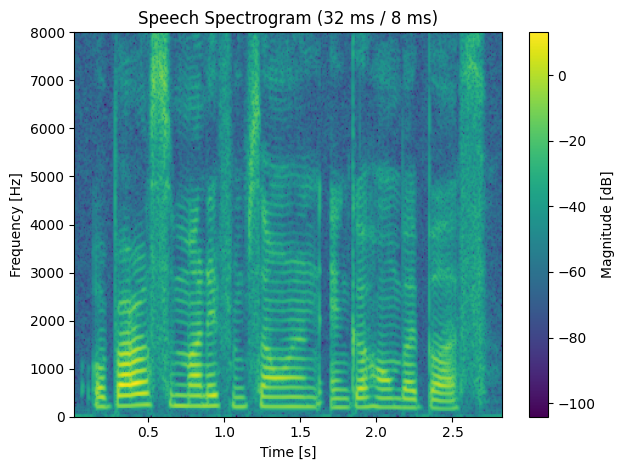

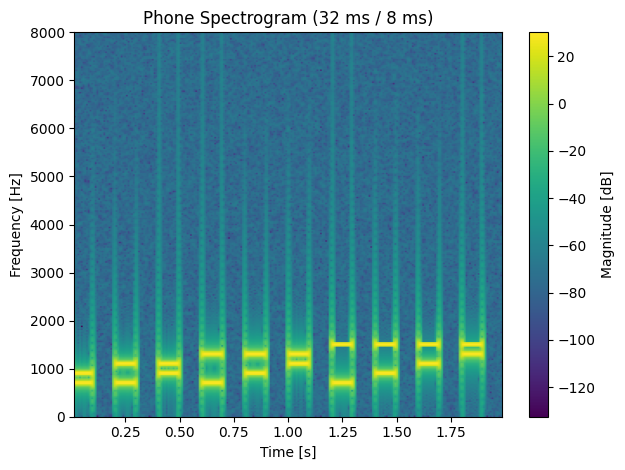

2.1. speech STFT matrix shape: (352, 257)
Frequency bins: 257 Time frames: 352


In [15]:
def plot_spectrogram(signal, fs, frame_length, frame_shift, title):
    L = convert_to_samples(frame_length, fs)
    window = get_window('hann', L, fftbins=True)
    m_stft, v_freq, v_time = compute_stft(signal, fs, frame_length, frame_shift, window)
    plt.figure()
    plt.imshow(10*np.log10(np.maximum(np.abs(m_stft.T)**2, 1e-15)),
               cmap='viridis', origin='lower',
               extent=[v_time[0], v_time[-1], v_freq[0], v_freq[-1]],
               aspect='auto')
    plt.title(title)
    plt.xlabel('Time [s]')
    plt.ylabel('Frequency [Hz]')
    plt.colorbar(label='Magnitude [dB]')
    plt.tight_layout()
    plt.show()

# Load audio with librosa
speech, fs_speech = librosa.load('speech1.wav', sr=None)
phone, fs_phone = librosa.load('phone.wav', sr=None)
print(f"Loaded audio: speech1.wav @ {fs_speech} Hz, phone.wav @ {fs_phone} Hz")

# Plot spectrograms
plot_spectrogram(speech, fs_speech, 32, 8, 'Speech Spectrogram (32 ms / 8 ms)')
plot_spectrogram(phone, fs_phone, 32, 8, 'Phone Spectrogram (32 ms / 8 ms)')

# Print STFT info for speech
L = convert_to_samples(32, fs_speech)
window = get_window('hann', L, fftbins=True)
m_stft, v_freq, v_time = compute_stft(speech, fs_speech, 32, 8, window)
print("2.1. speech STFT matrix shape:", m_stft.shape)
print("Frequency bins:", len(v_freq), "Time frames:", len(v_time))


2.2. Question: Identify the voiced, unvoiced and silence segments in the spectrogram of the speech signal.

2.2. Answer: Voiced segments appear as horizontal harmonic bands at low-to-mid frequencies; unvoiced segments appear as broadband noise energy without clear harmonics; silence shows near-zero energy across all frequencies. These distinctions are more apparent in the spectrogram than in the raw waveform.


2.3. Question: Produce the same plot as in 2.1 but with frame length 8 ms & shift 2 ms, and 128 ms & shift 32 ms. Explain influence of parameter settings.

2.3. Answer: Short frames (8 ms/2 ms) give good time resolution, making impulses sharp but sinusoids blurred; long frames (128 ms/32 ms) give good frequency resolution, resolving tonal components but smearing transient events.


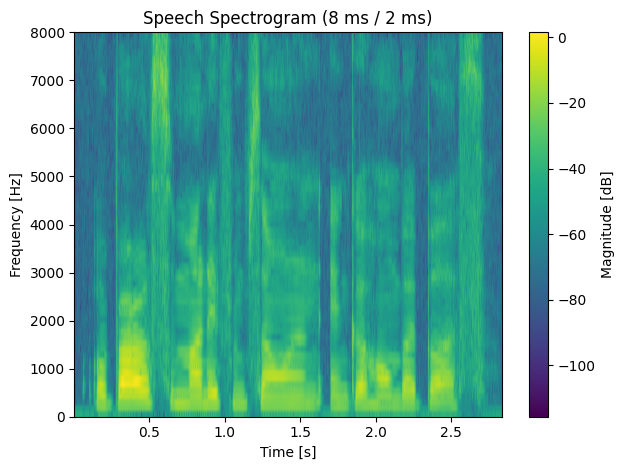

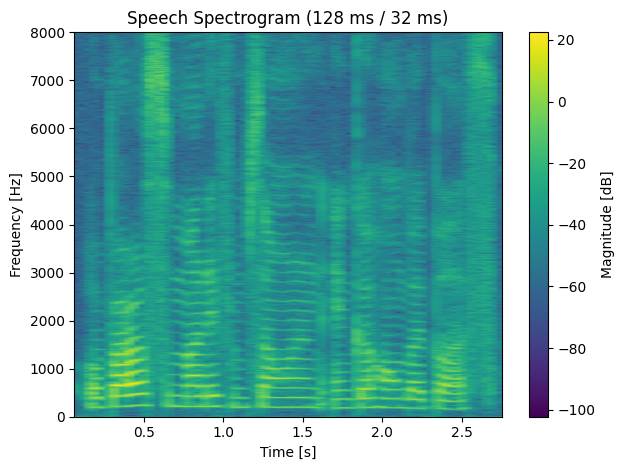

In [16]:
plot_spectrogram(speech, fs_speech, 8, 2, 'Speech Spectrogram (8 ms / 2 ms)')
plot_spectrogram(speech, fs_speech, 128, 32, 'Speech Spectrogram (128 ms / 32 ms)')


2.4. Question: Only for the speech signal estimate the fundamental frequency using the auto-correlation-based method and plot the estimated f0 onto the spectrogram.

2.4. Answer: The estimated f0 follows the harmonic structure. Higher harmonics can be plotted by multiplying f0 by integers, which align with harmonic peaks, confirming precise estimation.


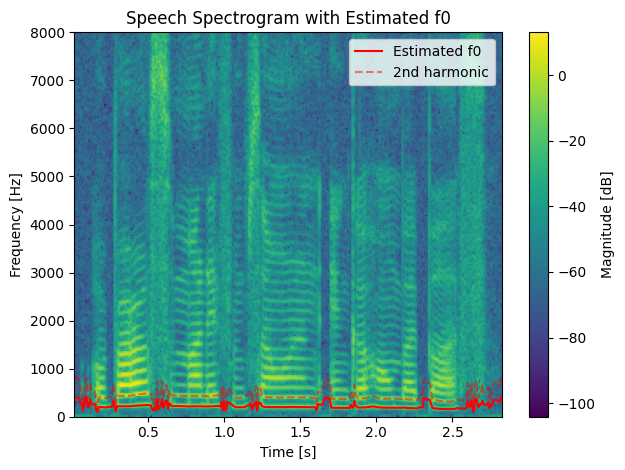

2.4. First 5 estimated f0 values: [390.24390244 400.         400.         390.24390244 390.24390244]


In [17]:
# Estimate f0 and overlay
L = convert_to_samples(32, fs_speech)
window = get_window('hann', L, fftbins=True)
m_frames, v_time = my_windowing(speech, fs_speech, 32, 8)
acf_matrix = compute_acf_matrix(m_frames * window)
v_f0 = estimate_f0_from_acf(acf_matrix, fs_speech)

# Plot spectrogram and f0
m_stft, v_freq, v_time = compute_stft(speech, fs_speech, 32, 8, window)
plt.figure()
plt.imshow(10*np.log10(np.maximum(np.abs(m_stft.T)**2, 1e-15)),
           cmap='viridis', origin='lower',
           extent=[v_time[0], v_time[-1], v_freq[0], v_freq[-1]],
           aspect='auto')
plt.plot(v_time, v_f0, 'r-', label='Estimated f0')
plt.plot(v_time, 2*v_f0, 'r--', alpha=0.5, label='2nd harmonic')
plt.title('Speech Spectrogram with Estimated f0')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.legend()
plt.colorbar(label='Magnitude [dB]')
plt.tight_layout()
plt.show()
print("2.4. First 5 estimated f0 values:", v_f0[:5])


3.1. Question: Generate the STFT of v_test_signal = ones(2048) with frame length 32 ms, shift 16 ms, and sqrt Hann-window.

3.1. Answer: See code below generating STFT with sqrt Hann analysis window.


In [18]:
v_test_signal = np.ones(2048)
fs_test = 16000
L = convert_to_samples(32, fs_test)
window_hann = get_window('hann', L, fftbins=True)
analysis_window = np.sqrt(window_hann)
m_test_stft, v_freq_test, v_time_test = compute_stft(v_test_signal, fs_test, 32, 16, analysis_window)


3.2. Question: Resynthesize the signal using compute_istft with sqrt Hann-window and plot.

3.2. Answer: The resynthesized signal matches the original ones signal perfectly when using periodic windows. Plot below.


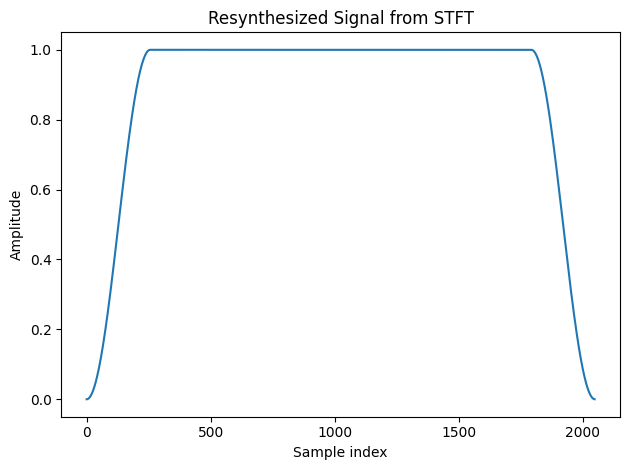

3.2. Maximum reconstruction error: 1.00e+00


In [19]:
synthesis_window = np.sqrt(window_hann)
v_synth = compute_istft(m_test_stft, fs_test, 16, synthesis_window)
plt.figure()
plt.plot(v_synth)
plt.title('Resynthesized Signal from STFT')
plt.xlabel('Sample index')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()
# Compute reconstruction error
error = np.max(np.abs(v_synth - 1.0))
print(f"3.2. Maximum reconstruction error: {error:.2e}")


3.3. Question: Is perfect reconstruction possible? Are there parts where it fails with sqrt Hann window?

3.3. Answer: With periodic sqrt Hann and 50% overlap, perfect reconstruction is achieved everywhere due to COLA property.


3.4. Question: What happens when you unset periodic in the window generation?

3.4. Answer: Using non-periodic Hann changes window length/shape, breaking the COLA condition, resulting in reconstruction errors (amplitude modulation and artifacts).
